# 4-7 pytorch實作: 使用預模型做遷移學習-物件偵測模型: 以人臉偵測為例(Part 1)

物件偵測模型會分成三大項目:

1. 人臉資料庫: 此資料庫是自行收集的數據。

2. 簡易物件偵測:建課程投影片前半部內容，會以MobileNet2v為架構下去修改接簡易detection Head。

3. YOLO物件偵測: 但網路架構不會弄成Miulti-scale Deteaction，會以MobileNet2v為架構下去修改接YOLO的detection Head。

>Part1只會介紹(1人臉資料庫)和(2簡易物件偵測)內容。


## 1. 人臉資料庫

此資料庫是自行收集的數據，我們先針對此資料庫做簡易的介紹和操作。

In [1]:
import os
from pathlib import Path
import xml.etree.ElementTree as ET
labelmap = {'background':0, 'face': 1}

def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def xml_parser(xml_path, anno_path):
    root = ET.parse(xml_path).getroot()
    filename = Path(str(anno_path) + '/' + root.find("./filename").text)
    bboxes=[]
    labels=[]
    for object_xml in root.iter('object'):
        label = object_xml.find('name').text.lower()
        bbox = object_xml.find('bndbox')
        xmin = int(bbox.find("xmin").text) 
        ymin = int(bbox.find("ymin").text) 
        xmax = int(bbox.find("xmax").text) 
        ymax = int(bbox.find("ymax").text) 
        bbox = [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)
        labels.append(labelmap[label])
    return filename, bboxes, labels

def generate_data_inf(annotations, anno_path):
    imagepaths = []
    bboxes = []
    for xml_path in annotations:
        filename, bboxs, labels = xml_parser(xml_path, anno_path)
        imagepaths.append(filename)
        bboxes.append([labels,bboxs])
    return imagepaths, bboxes

anno_path = Path('./dataset/FaceDetection/images')
annotations = filelist(anno_path, '.xml')
imagepaths, bboxes = generate_data_inf(annotations, anno_path)

### 加入一些沒有臉的背景圖

In [2]:
background_path = Path('./dataset/FaceDetection/background')
imagepaths_background = filelist(background_path, '.jpg')
bboxes_ground=[]
for i in imagepaths_background:
    bboxes_ground.append([[0], [[0,0,0,0]]])
imagepaths+=imagepaths_background
bboxes+=bboxes_ground

image shape:(443, 640, 3)
label:[1]
bbox:[[283, 123, 453, 312]]


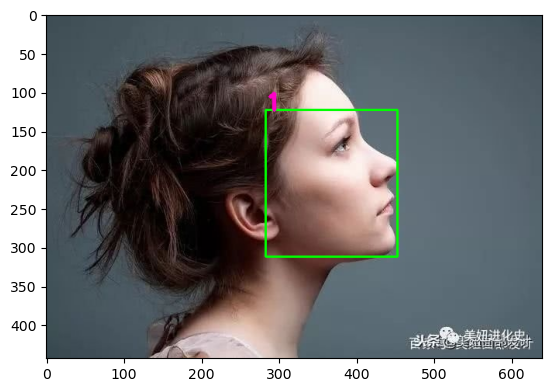

image shape:(1000, 1000, 3)
label:[1]
bbox:[[282, 299, 627, 659]]


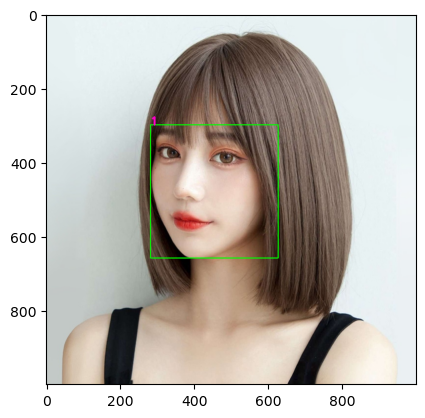

image shape:(460, 858, 3)
label:[1]
bbox:[[349, 112, 558, 314]]


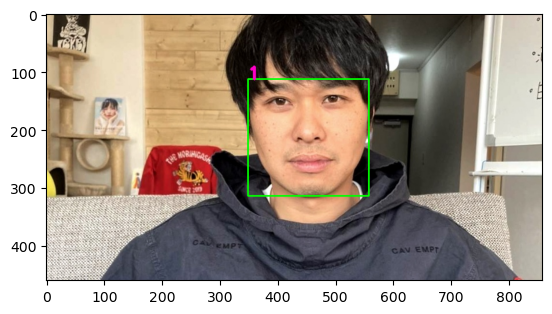

In [3]:
import cv2
import matplotlib.pyplot as plt
def plot_image_withbbox(img, bboxs, labels=[], flag_bgr=1):
    imageplot=img.copy()
    if len(labels)==0:
        for bb in bboxs:
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
    else:
        for bb, label in zip(bboxs,labels):
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
            cv2.putText(imageplot, str(label), (int(bb[0]),int(bb[1])), 0, 1, (200, 0, 255), 4, cv2.LINE_AA)
    if flag_bgr==1:
        plt.imshow(cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB))
    else:
         plt.imshow(imageplot)
    plt.show()

for data_id in [1,2,3]:
    im = cv2.imread(str(imagepaths[data_id]))
    bboxs = bboxes[data_id][1]
    labels = bboxes[data_id][0]
    print('image shape:{}'.format(im.shape))
    print('label:{}'.format(labels))
    print('bbox:{}'.format(bboxs))
    plot_image_withbbox(im, bboxs, labels)

### 將資料分成Train Set和Test Set

這邊隨機切割我們用自己寫的方式來做。

In [4]:
import numpy as np
n_data = len(imagepaths)
val_size = 0.2
n_val = int(n_data * val_size)
n_train = n_data - n_val
np.random.seed(2023)
randorder = np.random.permutation(n_data)


data_train = [imagepaths[randorder[tmp]]for tmp in range(n_train)]
bboxes_train = [bboxes[randorder[tmp]]for tmp in range(n_train)]
data_val = [imagepaths[randorder[tmp]]for tmp in range(n_train, n_data)]
bboxes_val = [bboxes[randorder[tmp]]for tmp in range(n_train, n_data)]
print('number of training data:{}'.format(len(data_train)))
print('number of validation data:{}'.format(len(data_val)))
print('number of total data:{}'.format(n_data))

def count_object(bboxes):
    n_object=np.zeros(2)
    for boxs in bboxes:
        if len(boxs[0])>2:
            for box in boxs[0]:
                n_object[box]+=1
        else:
            n_object[boxs[0]]+=1
    print(n_object)
print('number of object in training set:')
count_object(bboxes_train)
print('number of object in validation set:')
count_object(bboxes_val)


number of training data:471
number of validation data:117
number of total data:588
number of object in training set:
[ 25. 446.]
number of object in validation set:
[  5. 112.]


Note: 物件對應表在前面定義在 labelmap = {'background':0, 'face': 1,}

----------------------------
## 2. 簡易物件偵測
建課程投影片前半部內容，如下

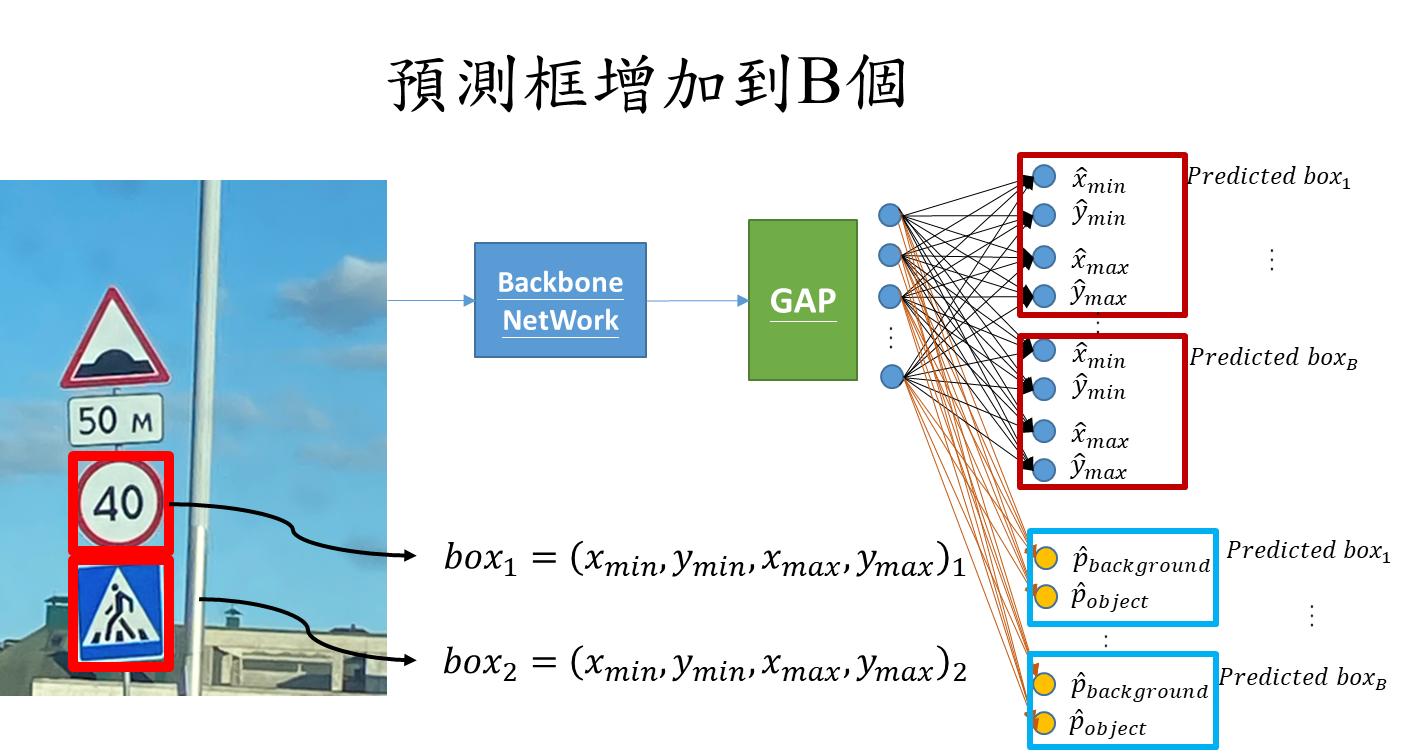

In [5]:
import torch.nn as nn
from torchvision import models
import torch
class objectdetection_model(nn.Module):
    def __init__(self, n_class, n_bbox):
        super(objectdetection_model, self).__init__()
        model_backbone = models.mobilenet_v2(pretrained=True)
        layers = list(model_backbone.children())[:-1]
        num_ftrs = layers[0][-1][0].out_channels
        self.features = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(num_ftrs, n_bbox*(n_class+1))
        self.bb = nn.Linear(num_ftrs, n_bbox * 4)
        
    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = self.flatten(x)
        return self.classifier(x), self.bb(x)
    
mymodel = objectdetection_model(n_class=1, n_bbox=2)
dummy_input = torch.randn(1, 3, 224, 224)
out = mymodel(dummy_input)


torch.onnx.export(mymodel, dummy_input, "objectdetection_model.onnx", opset_version=11) 

C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX檔案觀察我們接的層

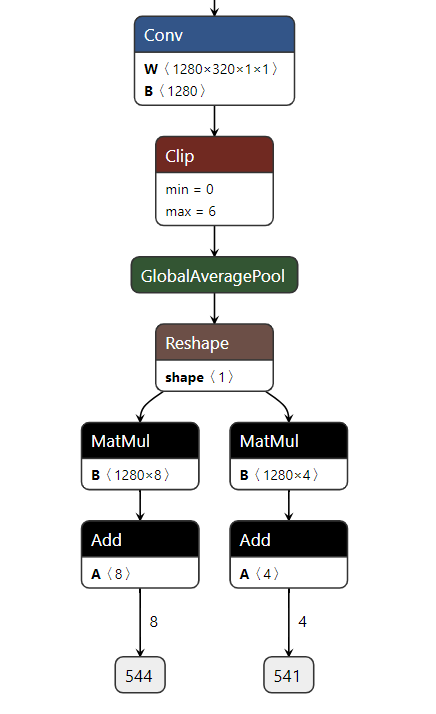

### 開始定義Dataloader 與 data transforms

圖須先轉換成固定大小，這邊我們先簡單寫個函數(resizewithbbox)將圖片的大小轉換為$224 \times 224$<br>
同時將對應的BBOX也需要跟著轉換。

original image


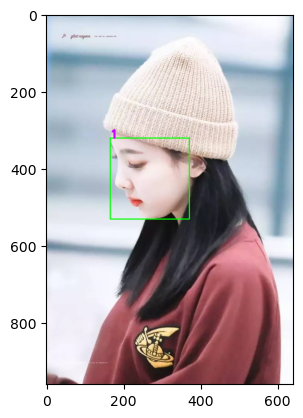

resized image


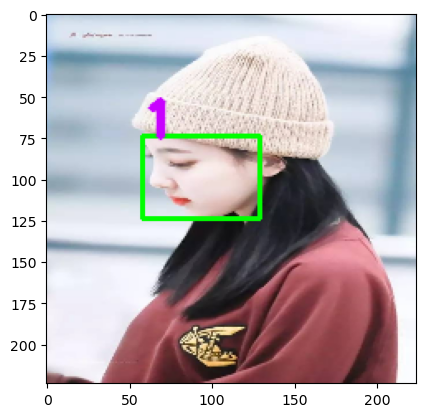

In [6]:
from PIL import Image

def resizewithbbox(image, bboxes, newsize=[224,224]):
    image = np.array(image)
    h,w,ch = image.shape
    new_w, new_h = newsize[0], newsize[1]
    scale_h, scale_w = new_h/h, new_w/w
    new_image = cv2.resize(image, (new_w, new_h))
    new_image = Image.fromarray(new_image)
    n = len(bboxes)
    new_bboxes = np.array(bboxes)
    if n:
        new_bboxes[:, 0] = new_bboxes[:, 0]*scale_w 
        new_bboxes[:, 1] = new_bboxes[:, 1]*scale_h 
        new_bboxes[:, 2] = new_bboxes[:, 2]*scale_w 
        new_bboxes[:, 3] = new_bboxes[:, 3]*scale_h 
    return new_image, new_bboxes

def zoom_out(image, bboxes):
    image = np.array(image)
    h,w,ch = image.shape
    img_aug = np.ones(image.shape,dtype=np.int8)*255
    
    ratio = np.random.choice([1.05,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9, 2])
    new_w = int(w/ratio)
    new_h = int(h/ratio)
    
    new_img, new_bboxes = resizewithbbox(image, bboxes, [new_w,new_h])
    new_img = np.array(new_img)
    
    remain_w = w - new_w
    remain_h = h - new_h
    if (remain_w>int(w/4))&(remain_h>int(h/4)):
        st_w = np.random.randint(int(w/4), remain_w)
        st_h = np.random.randint(int(h/4), remain_h) 
    else:
        st_w = np.random.randint(0, remain_w)
        st_h = np.random.randint(0, remain_h)
    
    img_aug[st_h:st_h+new_h, st_w:st_w+new_w,:]=new_img
    
    img_aug = Image.fromarray(np.uint8(img_aug))
    
    n = len(new_bboxes)
    new_bboxes = np.array(new_bboxes)
    if n:
        new_bboxes[:, 0] = new_bboxes[:, 0]+st_w  
        new_bboxes[:, 1] = new_bboxes[:, 1]+st_h
        new_bboxes[:, 2] = new_bboxes[:, 2]+st_w  
        new_bboxes[:, 3] = new_bboxes[:, 3]+st_h 
    return img_aug, new_bboxes


for image_id in [2]:
    image_path = data_train[image_id]
    bboxes = bboxes_train[image_id][1]
    labels = bboxes_train[image_id][0]
    print('original image')
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    imageplot=np.array(img.copy())
    plot_image_withbbox(imageplot, bboxes, labels,flag_bgr=0)

    print('resized image')
    new_img, new_bboxes = resizewithbbox(img, bboxes)
    imageplot=np.array(new_img.copy())
    plot_image_withbbox(imageplot, new_bboxes, labels,flag_bgr=0)



<font size=3> 
後續的圖片會利用torchvision的函數進行data transforms轉換 <br>
    1. 所有的圖片都需要用transforms.ToTensor，將8bits RGB PIL格式圖片(0-255)直接除上255轉換成(0-1)。<br>
    2. 利用transforms.Normalize將圖片進行正規化(Z-socre)，平均數和變異數採用ImageNet資料庫計算出來的值。<br>
    
針對訓練資料部分，將額外利用<br>
    transforms.ColorJitter(brightness=(0, 2), contrast=(
        0, 2), saturation=(0, 2), hue=(-0.3, 0.3))<br>
    進行資料擴增(data augumentation)。
</font>



original image


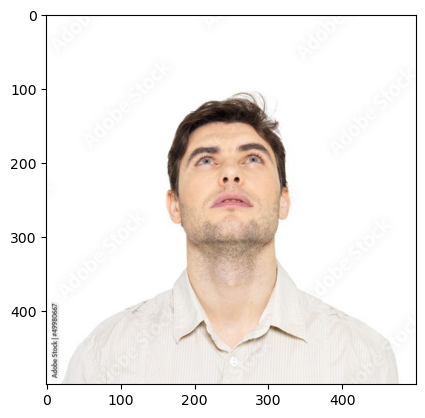

augumented image


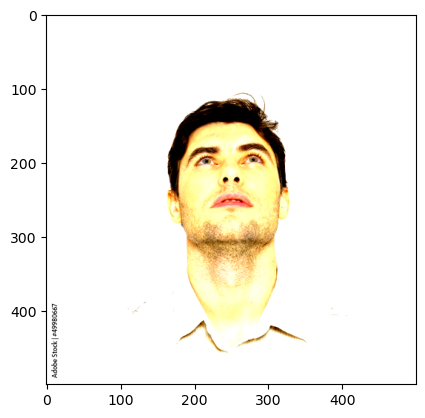

In [7]:
from torchvision import transforms
# image pre-process
process_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
)
transforms_dataaug = transforms.ColorJitter(brightness=(0.5, 1.5), 
                                            contrast=(0.5, 1.5), 
                                            saturation=(0.5, 1.5), 
                                            hue=(-18/255, 18/255))

###### Visualization for example #######
image_id = 5    
image_path = data_train[image_id]
img = Image.open(image_path, mode='r')
img = img.convert('RGB')
img_trans = transforms_dataaug(img)
print('original image')
plt.imshow(np.array(img))
plt.show()
print('augumented image')
plt.imshow(np.array(img_trans))
plt.show()

### 定義Dataloader
<font size=3> 
1. 圖片讀進來後，採用RGB格式<br><br>
2. 圖片和BBOX需要resize到正方形(原因比較好操作後續計算)，此例會將圖片resize到(224x224)<br><br>
3. 如果是training phase則需要做Data Augumentation(我用is_transforms引入)，並且以30%的機率來進行。<br><br>
4. Ground Truth的BBOX座標會被正規化到0~1: <br>所以假設resize後的座標是$(56,112)$，則模型學習的目標會轉換成
    $$(\frac{56}{224}, \frac{112}{224})=(0.25, 0.5)$$ <br><br>
</font>


In [8]:
from torch.utils.data import Dataset, DataLoader
# image pre-process
process_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
)
transforms_dataaug = transforms.ColorJitter(brightness=(0.5, 1.5), 
                                            contrast=(0.5, 1.5), 
                                            saturation=(0.5, 1.5), 
                                            hue=(-18/255, 18/255))

class FaceDataset(Dataset):
    def __init__(self, image_paths, bboxes, newsize=[224,224], is_transforms=False):
        self.is_transforms = is_transforms
        self.image_paths = image_paths
        self.bboxes = bboxes
        self.newsize=newsize
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        bboxes = self.bboxes[idx]
        
        # 1.
        img = Image.open(path, mode='r')
        img = img.convert('RGB')
        bboxs = bboxes[1]
        bboxs_class = bboxes[0]
                
        # 2.
        img, bboxs = resizewithbbox(img, bboxs, newsize=self.newsize)

        # 3. 
        if self.is_transforms:
            if np.random.random()<0.3:
                img, bboxs = zoom_out(img, bboxs)
        if self.is_transforms:
            if np.random.random()<0.3:
                img = transforms_dataaug(img)
                
        img = process_transforms(img)
        bboxs_class= torch.tensor(bboxs_class)
        
        # 4.
        bboxs = bboxs/self.newsize[0]
        xs= bboxs[:,0] + (bboxs[:,2]-bboxs[:,0])/2
        ys= bboxs[:,1] + (bboxs[:,3]-bboxs[:,1])/2
        ws= np.abs(bboxs[:,2]-bboxs[:,0])
        hs= np.abs(bboxs[:,3]-bboxs[:,1])
            
        bboxs= np.zeros(bboxs.shape)
        bboxs[:,0] = xs
        bboxs[:,1] = ys
        bboxs[:,2] = ws
        bboxs[:,3] = hs
        bboxs = torch.FloatTensor(bboxs)
#         bboxs = torch.FloatTensor(bboxs/self.newsize[0])
        return img, bboxs, bboxs_class
    
    def collate_fn(self, batch):
        imgs = list()
        bboxes = list()
        bboxes_class = list()
        for b in batch:
            imgs.append(b[0])
            bboxes.append(b[1])
            bboxes_class.append(b[2])
        imgs=torch.stack(imgs,dim=0)
        return imgs, bboxes, bboxes_class
  

### 簡易物件偵測訓練的Loss Function定義

假設圖片為$x$，模型為$f$，偵測目標總共有C類，模型一共預測B個物件框
    
$$
\hat {BBox}_i = f(x), i=1,2,...,B  \\
\hat {BBox}_i = [(\hat x, \hat y,\hat H, \hat W), (p_0, p_1,...,p_C)]
$$
<br>
Ground Truth的BBOX:
$$
BBox_i = [(x, y, H, W), OneHotEncode(C)]
$$

<br>
    
**Loss設計目標:**
    
<br>
1. BBox座標逼近ground truth的座標，我這邊設計用L1 norm:<br>
$$
(\hat x, \hat y,\hat H, \hat W) \to (x, y, H, W) \\
loss(box)=|\hat x - x|+|\hat y - y|+|\hat H - H|+|\hat W - W|
$$    
2. BBox分類採Cross Entropy:<br>
$$
loss(CE)=\sum_{i}^{B} CrossEntropy(BBox_{i}, C)
$$

學習目標:
$$
loss = 2*loss(box) + loss(CE)
$$


In [9]:
import torch.nn.functional as F
class LOSS_OD(nn.Module):
    def __init__(self, n_bbox, n_class):
        super(LOSS_OD,self).__init__()
        self.n_bbox = n_bbox
        self.n_class = n_class
        self.Softmax= nn.Softmax(dim=2)
    def forward(self, preds_bb, preds_class, bboxs, bboxs_class):
        # preds_bb:  n_batch * (n_bbox*4 =24)
        # preds_class: n_batch * (n_bbox*(n_class+1)= 30)
        # bboxs: batch * n_object * 4
        # bboxs_class: batch * n_object 
        n_bbox = self.n_bbox
        n_class = self.n_class
        
        batch_size = preds_bb.size(0)
        
        preds_class = torch.reshape(preds_class,(batch_size, n_bbox, n_class+1)) # (batch, n_bbox, n_class+1)
        preds_class = self.Softmax(preds_class)
        
        preds_bb = torch.reshape(preds_bb,(batch_size, n_bbox, 4)) # (batch, n_bbox, 4)
        loss_conf,  loss_locs = 0,0
        
        for b in range(batch_size):
            sub_bboxs = bboxs[b]
            sub_bboxs_class = bboxs_class[b]
            n_object = sub_bboxs.size(0)
            if n_object==0:
                continue        
            pred_class = preds_class[b,0:n_object,:] # n_object=1
            pred_bb = preds_bb[b,0:n_object,:]
            loss_conf +=  F.cross_entropy(pred_class.view(-1,n_class+1),sub_bboxs_class , reduction="sum")
            loss_locs += F.l1_loss(pred_bb, sub_bboxs, reduction="sum")
        return 2*loss_locs + loss_conf

### 開始訓練

In [10]:
use_cuda = 1
device = torch.device("cuda:0" if use_cuda&torch.cuda.is_available() else "cpu")
epochs = 50
n_class = 1
n_bbox = 3 # 模型要最多能預測多少物件
lr = 0.001
batch_size = 32

# training -> is_transforms=True
# validation/test -> is_transforms=False
dataset_train = FaceDataset(data_train, bboxes_train, newsize=[224,224], is_transforms=True) 
dataset_val   = FaceDataset(data_val,   bboxes_val,   newsize=[224,224], is_transforms=False) 
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=dataset_train.collate_fn)
valid_dl = DataLoader(dataset_val  , batch_size=batch_size, shuffle=True, collate_fn=dataset_val.collate_fn)

model = objectdetection_model(n_class=n_class, n_bbox=n_bbox).to(device)

loss_od = LOSS_OD(n_bbox=n_bbox, n_class=n_class)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [11]:
import time
loss_train_log, loss_val_log=[],[]
loss_all_train_log, loss_all_val_log=[],[]
for e in range(epochs):
    # training step
    model.train()
    total, sum_loss = 0, 0
    st=time.time()
    c=0
    for imgs, bboxs, bboxs_class in train_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        
        preds_class, preds_bb = model(imgs)
        loss = loss_od(preds_bb, preds_class, bboxs, bboxs_class)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += len_batch
        sum_loss += loss.item()
        loss_all_train_log.append(loss.item())
        
        c+=1
    time_train =  time.time()-st
    train_loss = sum_loss / total
    loss_train_log.append(train_loss)
    
    # eval
    model.eval()
    total, sum_loss = 0, 0
    st=time.time()
    for imgs, bboxs, bboxs_class in valid_dl:
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        bboxs_class = [l.to(device) for l in bboxs_class]
        with torch.no_grad():
            preds_class, preds_bb = model(imgs)
            loss = loss_od(preds_bb, preds_class, bboxs, bboxs_class)
            
        total += len_batch
        sum_loss += loss.item()
        loss_all_val_log.append(loss.item())
    time_val =  (time.time()-st) 
    eval_loss = sum_loss / total
    loss_val_log.append(eval_loss)
    if e % 5 == 0:
        print("Epoch[{}/{}], lr={:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, train_time:{:.4f},val_time:{:.4f}".format(e+1,
                                                                                                               epochs,
                                                                                                               scheduler.get_last_lr()[0],
                                                                                                               train_loss, 
                                                                                                               eval_loss,
                                                                                                               time_train,
                                                                                                               time_val))
    scheduler.step()
    

Epoch[1/50], lr=0.001000, train_loss: 2.5476, val_loss: 3.6275, train_time:9.4227,val_time:1.7715
Epoch[6/50], lr=0.001000, train_loss: 0.8730, val_loss: 1.2540, train_time:8.8627,val_time:1.5808
Epoch[11/50], lr=0.000100, train_loss: 0.6532, val_loss: 0.6430, train_time:9.2296,val_time:1.4756
Epoch[16/50], lr=0.000100, train_loss: 0.5960, val_loss: 0.6104, train_time:8.8772,val_time:1.4377
Epoch[21/50], lr=0.000010, train_loss: 0.5637, val_loss: 0.5666, train_time:8.1558,val_time:1.5110
Epoch[26/50], lr=0.000010, train_loss: 0.5502, val_loss: 0.5595, train_time:8.2225,val_time:1.4597
Epoch[31/50], lr=0.000001, train_loss: 0.5567, val_loss: 0.5647, train_time:7.5328,val_time:1.3019
Epoch[36/50], lr=0.000001, train_loss: 0.5441, val_loss: 0.5587, train_time:7.8349,val_time:1.3010
Epoch[41/50], lr=0.000000, train_loss: 0.5326, val_loss: 0.5577, train_time:8.1500,val_time:1.5008
Epoch[46/50], lr=0.000000, train_loss: 0.5522, val_loss: 0.5562, train_time:7.5851,val_time:1.3180


In [12]:
checkpoint={}
checkpoint['loss_train_log']=loss_train_log
checkpoint['loss_val_log']=loss_val_log
checkpoint['loss_all_train_log']=loss_all_train_log
checkpoint['loss_all_val_log']=loss_all_val_log
checkpoint['model_dict'] = model.state_dict()
torch.save(checkpoint, 'Model_facedetection.pth')
print('Model saved.')


Model saved.


### 訓練和Validation損失函數變化

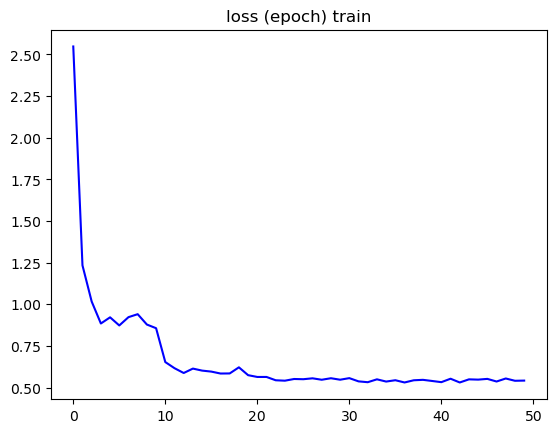

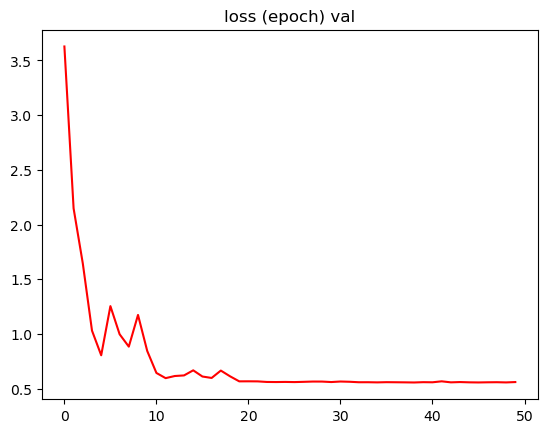

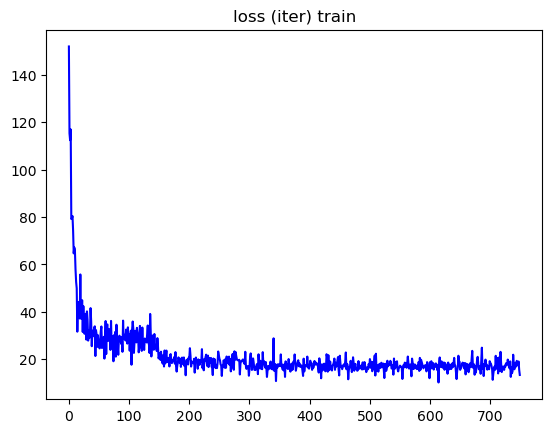

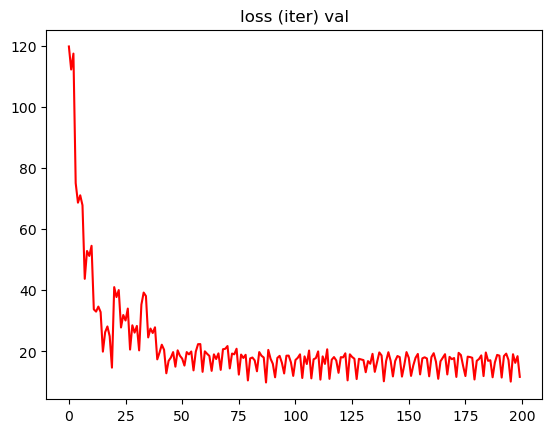

In [13]:
plt.plot(loss_train_log[:],'b')
plt.title('loss (epoch) train')
plt.show()

plt.plot(loss_val_log[:],'r')
plt.title('loss (epoch) val')
plt.show()

plt.plot(loss_all_train_log[:],'b')
plt.title('loss (iter) train')
plt.show()

plt.plot(loss_all_val_log[:],'r')
plt.title('loss (iter) val')
plt.show()

### 從我給的模型權重進行Model Inference (CPU)

In [15]:
n_class = 1
n_bbox = 3 # 模型要最多能預測多少物件
checkpoint = torch.load('Model_facedetection.pth', map_location=torch.device('cpu'))
model = objectdetection_model(n_class=n_class, n_bbox=n_bbox)
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

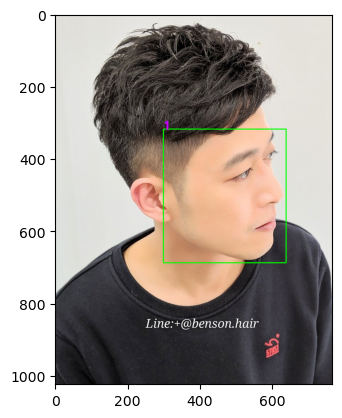

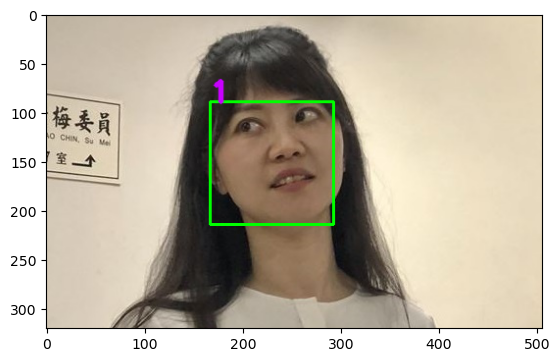

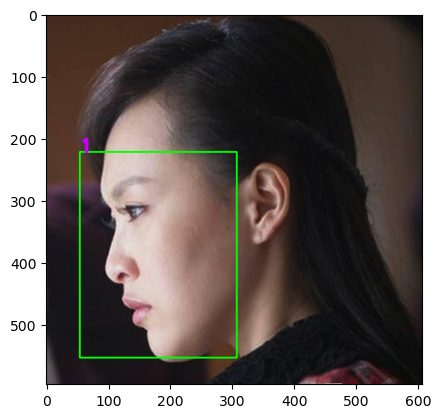

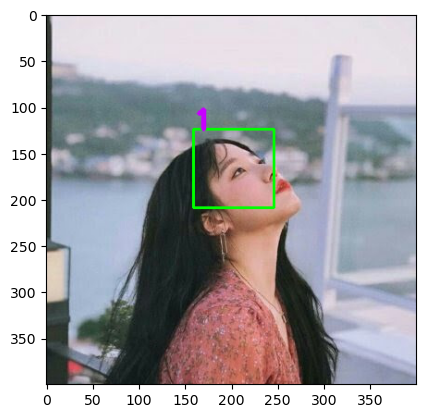

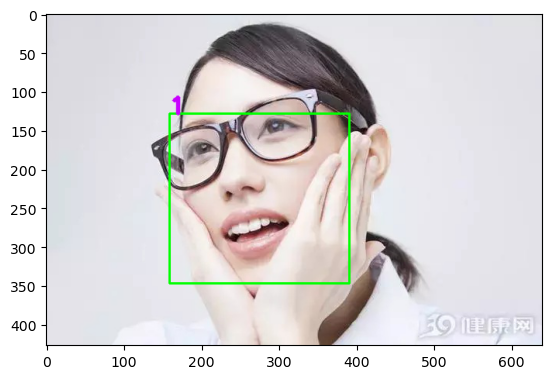

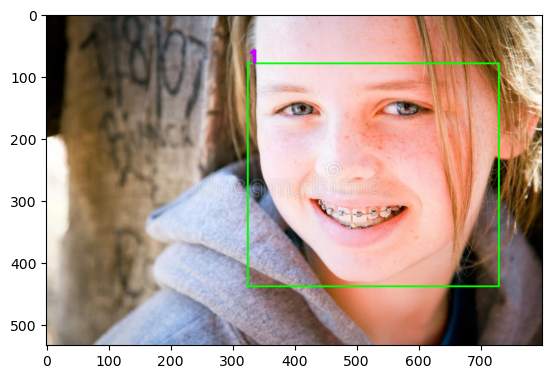

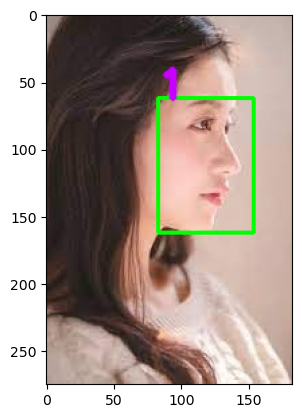

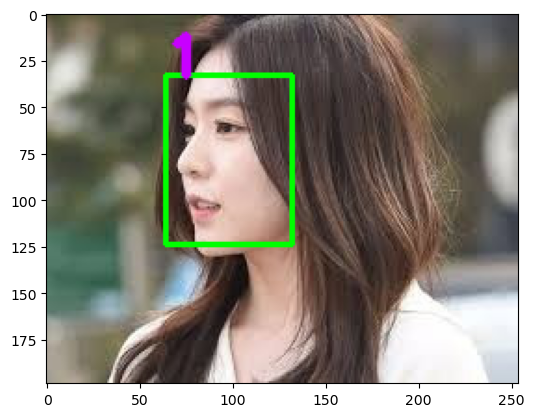

In [17]:
for image_id in [0,5,10,15,20,25,30,50]:
    image_path = data_val[image_id]

    # load image
    img = Image.open(image_path, mode='r')
    img = img.convert('RGB')
    original_w, original_h = img.size
    imageplot=np.array(img.copy())
    
    # convert to torch tensor
    img, _ = resizewithbbox(img, [],newsize=[224,224])
    resize_img=np.array(img.copy())
    img = process_transforms(img) # 3*224*224
    img = img.unsqueeze(dim=0)#  1 * 3*224*224

    # model inference
    model.eval()
    with torch.no_grad():
        preds_class, preds_bb = model(img) # batch*3*224*224

    # Decode localization
    preds_bb = preds_bb[0]
    preds_bb = torch.reshape(preds_bb,(n_bbox, 4)) # (batch, n_bbox, 4)
    preds_bb = preds_bb.detach().cpu().numpy()
    w_half = preds_bb[:,2]/2
    h_half = preds_bb[:,3]/2
    x_min = preds_bb[:,0]-w_half
    y_min = preds_bb[:,1]-h_half
    x_max = preds_bb[:,0]+w_half
    y_max = preds_bb[:,1]+h_half
    preds_bb[:,0]=x_min*original_w
    preds_bb[:,1]=y_min*original_h
    preds_bb[:,2]=x_max*original_w
    preds_bb[:,3]=y_max*original_h


    # Decode classifiction
    preds_class = preds_class[0]
    preds_class = torch.reshape(preds_class,(n_bbox, n_class+1)) # ( n_bbox, n_class+1)
    preds_class = nn.Softmax(dim=1)(preds_class)
    v, ind = torch.max(preds_class,dim=1)
    v = v.detach().cpu().numpy()
    ind = ind.detach().cpu().numpy()
    
    p_bbox, final_bbox=[],[]
    final_label=[]
    for i,tmp_ind in enumerate(ind):
        if tmp_ind > 0:
            p_bbox.append(preds_class[i,tmp_ind])
            final_bbox.append(preds_bb[i,:])
            final_label.append(tmp_ind)
    
    # 畫圖     
    plot_image_withbbox(imageplot, final_bbox, final_label, flag_bgr=0)


# Note: 物件對應表在前面定義在 labelmap = {'background':0, 'face': 1}

 